In [150]:
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,10))
import pandas as pd
from scipy import optimize

<Figure size 864x720 with 0 Axes>

In [165]:
df=pd.read_csv('10YRS.csv')
df['Date']

0       1992-12-31
1       1993-01-04
2       1993-01-05
3       1993-01-06
4       1993-01-07
           ...    
6257    2017-11-02
6258    2017-11-03
6259    2017-11-06
6260    2017-11-07
6261    2017-11-08
Name: Date, Length: 6262, dtype: object

In [152]:
dff=df['Adj Close'].dropna()
dff=dff.tolist()

In [157]:
def OUKalman(): 
    global Obs
    global TimeDelta
    global xVec
    
    #mean reversion rate
    lambda_=1
    #long-term mean
    mu=3
    #Driving Sigma
    Dsig =2
    #Initial Price
    Szero=3; 
    stepsInput = len(dff) 
    TimeLength=5;
    S=Obs=np.zeros(stepsInput) 
    Obs=np.zeros(stepsInput)
    time = np.linspace(0,TimeLength,stepsInput)  
    TimeDelta= time[1]-time[0]
    SimulateOUkalman (mu, lambda_, Dsig,Szero, stepsInput)
    xVec=np.zeros(stepsInput) 

    #Supply initial guess values
    muGuess=9
    lambdaGuess=2
    sigGuess=0.9
    RGuess=0.01
    param=np.zeros((4,1));
    param[0,0]=muGuess;
    param[1,0]=lambdaGuess;
    param[2,0]=sigGuess;
    param[3,0]=RGuess;
    pnew = scipy.optimize.fmin(OUloglikelihoodfn,param )
    muNew = pnew[0]
    lambdaNew = pnew[1];
    DsigNew = pnew[2];
    RNew = pnew[3];
    print( 'Parameters\t\t mu \t lambda \t sigma \n'); 
    print( 'True\t\t\t',round(mu,2),'\t ',' ',round(lambda_,2),'\t\t',round(Dsig,2))
    print('Estimated\t\t',round(muNew,2),'\t ',' ',round(lambdaNew,2),'\t',round(DsigNew,2),'\n')
    print('Measurement Noise Covariance = R =',round(RNew,4));
    fig=plt.figure(figsize=(12,10))
    plt.plot (time,LnS,label='Real Price',linewidth=0.5)
    plt.plot(time, Obs,'--',label='Observed Price',linewidth=0.5)
    plt.plot(time, xVec, '-.',label='Predicted Price')
    plt.xlabel('Time'); 
    plt.ylabel('Asset Price')
    #plt.axis(xmin=0,xmax=5,ymin=0,ymax=7)
    plt.legend()
    plt.savefig('real_1.png')



In [158]:
def SimulateOUkalman (mu,lambda_,  Dsig, Szero, steps):
    global LnS
    #LnS=
    global Obs; 
    global TimeDelta;
    #Expected = LnSzero.*exp(-lambda.*time)+mu.*(1-exp(-lambda*time)));
    M=np.exp(-lambda_*TimeDelta)
    #=mu.*(1-exp(-lambda*TimeDelta)
    C=mu*(1-M) 
    SD= Dsig*np.sqrt( (1-np.exp(-2*lambda_*TimeDelta))/ (2*lambda_));
    #covariance of unobservable process
    Q=SD**2; 
    R=0.01;
   #assume (co)variance of observable process is small but
    H=1; #We are directly observing spot price -> H(matrix)=1
    noise_w=SD*np.random.randn(steps);
    noise_v=np.sqrt(R)*np.random.randn(steps)
    Obs[0]= H*LnS[0]+noise_w[0]
    
    for i in range(1,steps):
        #S= Expected + SD.*randn(1,steps);
        #LnS[i]=C+M*dff[i-1]+noise_w[i]
        #Z=Obs=Hx+v v~N(0,R)
        Obs[i]=H*LnS[i]+noise_v[i]

In [159]:
def OUloglikelihoodfn(parameter):
    global xVec
    global TimeDelta
    global Obs
    mu=parameter[0];
    lambda_=parameter[1];
    sig=parameter[2];
    R=parameter[3]; 
    H=1;
    M=np.exp(-lambda_*TimeDelta);
    C=mu*(1-M);
    nsamples=len(Obs);#size(Obs,2);
    LikeSum=0.5*nsamples*np.log(2*np.pi);
    x=H*Obs[0];
    xVec[0]=x;
    if lambda_==0: 
        Q= sig*sig*( (1-exp(-2*lambda_*TimeDelta))/(2*lambda_));
    else:
        Q= sig*sig*(TimeDelta);
    
    P=H*Q*np.transpose(H)
        
    for i in range(1,nsamples):
        x = M*x+C;  
        P = M*P*np.transpose(M)+ Q
        #%Measurement (Innovation
        MR = Obs[i]- H*x
        
        V = H*P*np.transpose(H) + R;
        K = P*H * V**(-1)
        #posteriori estimate
        x = x + K*(MR)
        #posterior error covariance
        P = P-K*H*P
        LikeSum=LikeSum +0.5*np.log(V)+0.5*MR*V**(-1)*MR
        xVec[i]=x
    return LikeSum

Optimization terminated successfully.
         Current function value: -3736.459935
         Iterations: 156
         Function evaluations: 273
Parameters		 mu 	 lambda 	 sigma 

True			 3 	    1 		 2
Estimated		 3.22 	    0.84 	 2.01 

Measurement Noise Covariance = R = 0.0101


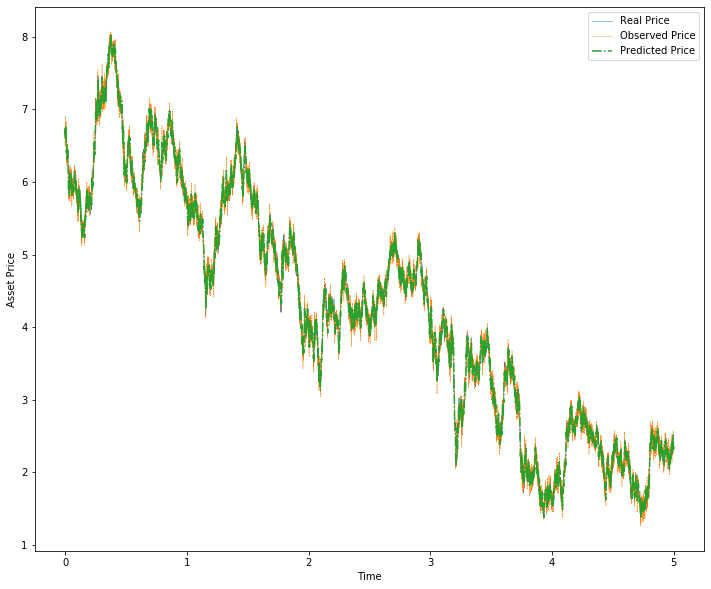

In [160]:
OUKalman()

In [142]:
xVec

array([6.69431416, 6.70450011, 6.71061779, ..., 2.3239269 , 2.2506703 ,
       2.2876913 ])

In [136]:
LnS

[6.7,
 6.6,
 6.61,
 6.63,
 6.76,
 6.75,
 6.71,
 6.72,
 6.71,
 6.65,
 6.6,
 6.59,
 6.61,
 6.6,
 6.57,
 6.48,
 6.5,
 6.48,
 6.44,
 6.39,
 6.38,
 6.46,
 6.45,
 6.39,
 6.32,
 6.37,
 6.41,
 6.4,
 6.37,
 6.35,
 6.34,
 6.28,
 6.17,
 6.15,
 6.09,
 5.92,
 6.01,
 6.03,
 6.03,
 5.94,
 5.95,
 5.88,
 5.83,
 5.9,
 5.85,
 5.91,
 5.97,
 5.96,
 6.11,
 6.17,
 6.06,
 6.02,
 5.93,
 5.95,
 5.96,
 5.91,
 5.95,
 5.98,
 6.09,
 6.06,
 6.02,
 6.03,
 6.06,
 6.16,
 6.13,
 6.08,
 6.07,
 5.97,
 5.92,
 5.93,
 5.9,
 5.88,
 5.89,
 5.87,
 5.87,
 5.86,
 5.85,
 5.89,
 5.94,
 6.02,
 6.03,
 5.99,
 6.05,
 5.96,
 5.92,
 5.93,
 5.89,
 5.92,
 5.89,
 5.89,
 5.96,
 6.02,
 6.03,
 6.07,
 6.15,
 6.11,
 6.09,
 6.16,
 6.16,
 6.17,
 6.12,
 6.11,
 6.16,
 6.07,
 6.06,
 6.02,
 6.11,
 6.08,
 6.09,
 6.07,
 6.07,
 5.97,
 5.97,
 5.96,
 5.96,
 5.93,
 5.97,
 5.92,
 5.91,
 5.91,
 5.88,
 5.84,
 5.8,
 5.79,
 5.8,
 5.8,
 5.76,
 5.8,
 5.8,
 5.78,
 5.76,
 5.75,
 5.78,
 5.72,
 5.72,
 5.71,
 5.71,
 5.75,
 5.83,
 5.9,
 5.95,
 5.93,
 5.92,
 5.9,
 5.81,
